<a href="https://colab.research.google.com/github/belugarose/gbdt/blob/master/titanic_gbdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams]]

## 数据的预处理

In [113]:
filepath = "/content/train.csv"
train_df = pd.read_csv(filepath)
train_df.drop(columns=["Name", 'Ticket', 'Fare', 'Cabin'], inplace=True)
train_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

train_df[['Sex', 'Embarked']] = train_df[['Sex', 'Embarked']].apply(LabelEncoder().fit_transform)

In [32]:
target = "Survived"
predictors = [x for x in train_df.columns if x not in [target, "PassengerId"]]

In [117]:
def fit(model, train, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
  model.fit(train[predictors], train[target])

  # Predict training set
  train_predictions = model.predict(train[predictors])
  train_predprob = model.predict_proba(train[predictors])[:, 1]

  # Perform cross-validation
  if performCV:
    cv_score = cross_val_score(model, train[predictors], train[target], cv=cv_folds, scoring='roc_auc')

  print("Model Report")
  print("Accuracy : %.4g" % metrics.accuracy_score(train[target].values, train_predictions))
  print("AUC Score (Train): %f" % metrics.roc_auc_score(train[target], train_predprob))

  if performCV:
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

  #Print Feature Importance:
  if printFeatureImportance:
    feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Model Report
Accuracy : 0.8736
AUC Score (Train): 0.940735
CV Score : Mean - 0.8707268 | Std - 0.03928301 | Min - 0.8274848 | Max - 0.9436576


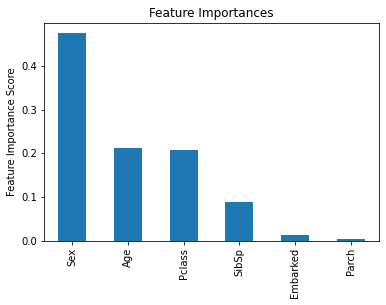

In [118]:
gbm = GradientBoostingClassifier(random_state=10)
fit(gbm, train_df, predictors)

## 参数调节

接下来我们来调节树参数和boosting参数。下面的步骤是一个例子。
- 选择一个相对来说高一点的lr。一般默认的值是0.1，针对不同的问题，0.05到0.2之间都可以。
- 当前lr下最优的决定树数量。大概在40-70之间。
- 降低lr，同时增加相应的决定树数量让模型更加稳健。

### 使用GridSearchCV调参

首先根据lr的默认值0.1来找到所需要的最佳的决定树数量。

In [176]:
param_test1 = {'n_estimators':range(10, 300, 10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=60,min_samples_leaf=10,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), param_grid=param_test1, scoring='roc_auc',n_jobs=4,cv=5)

gsearch1.fit(train_df[predictors],train_df[target])

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=10,
                                                  min_samples_split=60,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
     

In [178]:
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_

(array([0.86133109, 0.86723176, 0.87201357, 0.87489069, 0.87376683,
        0.87208319, 0.87319326, 0.87297713, 0.87088933, 0.86960033,
        0.86913001, 0.86724815, 0.86768812, 0.86630968, 0.86480559,
        0.86255526, 0.86292939, 0.86154032, 0.86001852, 0.85911799,
        0.85850591, 0.85992846, 0.85929241, 0.85990586, 0.85944175,
        0.85837597, 0.85730977, 0.8578417 , 0.8564995 ]),
 {'n_estimators': 40},
 0.8748906876725282)

确定了决定树的数量之后可以按照这些步骤调节参数
1. 调节max_depth, min_samples_split
2. 调节min_samples_leaf
3. 调节max_features

In [145]:
param_test2 = {'max_depth': range(5, 20, 1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=35,min_samples_split=60,min_samples_leaf=10,max_features='sqrt',subsample=0.8,random_state=10), param_grid=param_test2, scoring='roc_auc',n_jobs=4,cv=5)

gsearch2.fit(train_df[predictors],train_df[target])
gsearch2.cv_results_['mean_test_score'], gsearch2.best_params_, gsearch2.best_score_

(array([0.87509856, 0.87141455, 0.87395338, 0.87514363, 0.87119504,
        0.87277754, 0.87316635, 0.87324891, 0.87324891, 0.87324891,
        0.87324891, 0.87324891, 0.87324891, 0.87324891, 0.87324891]),
 {'max_depth': 8},
 0.8751436273238877)

In [165]:
param_test3 = {'min_samples_split': range(5, 80, 5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=35,max_depth=8,min_samples_leaf=10,max_features='sqrt',subsample=0.8,random_state=10), param_grid=param_test3, scoring='roc_auc',n_jobs=4,cv=5)

gsearch3.fit(train_df[predictors],train_df[target])
gsearch3.cv_results_['mean_test_score'], gsearch3.best_params_, gsearch3.best_score_

(array([0.86918609, 0.86918609, 0.86918609, 0.86918609, 0.87109596,
        0.87174987, 0.87201336, 0.87158122, 0.8721708 , 0.86970816,
        0.87096548, 0.87514363, 0.87104576, 0.8736416 , 0.87223669]),
 {'min_samples_split': 60},
 0.8751436273238877)

调的差不多了，就可以接着去调整lr和树的数量了。我试着把lr调至0.01，树的数目增加至10倍。

Model Report
Accuracy : 0.8581
AUC Score (Train): 0.932599
CV Score : Mean - 0.8737536 | Std - 0.03156261 | Min - 0.8419878 | Max - 0.9342159


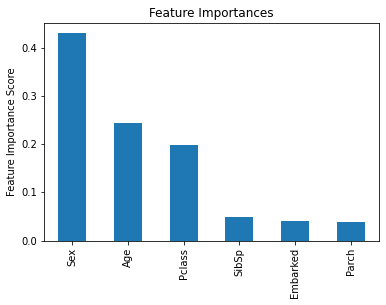

In [198]:
gbm = GradientBoostingClassifier(learning_rate=0.005,n_estimators=1200,max_depth=8,min_samples_split=60,min_samples_leaf=10,max_features='sqrt',subsample=0.8,random_state=10)
fit(gbm, train_df, predictors)